# Import Libraries and Clone Github

In [1]:
# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata

In [2]:
# Global Variables
SENTIMENT_COLUMNS = [
    'Finance',
    'Production',
    'Reserves / Exploration / Acquisitions / Mergers / Divestments',
    'Environment / Regulatory / Geopolitics',
    'Alternative Energy / Lower Carbon',
    'Oil Price / Natural Gas Price / Gasoline Price']

PALETTE = {'Positive': '#66c2a5', 'Neutral': '#8da0cb', 'Negative': '#fc8d62'}

HUE_ORDER = ['Positive', 'Neutral', 'Negative']

In [3]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 2316, done.
remote: Counting objects: 100% (721/721), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 2316 (delta 455), reused 636 (delta 379), pack-reused 1595
Receiving objects: 100% (2316/2316), 471.17 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (1538/1538), done.
Updating files: 100% (1169/1169), done.


In [5]:
# Import Sentiment Data
sentiment_df = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/Prompt2_Sentiment_Analysis_Results.csv')

# Define custom date parsing function as dates are in different formats sometimes
def parse_dates(date):
    """
    Parse dates from multiple formats into datetime objects.

    This function attempts to parse a date string into a pandas datetime object
    using a list of predefined formats. If the date string does not match any
    of the specified formats, it returns `pd.NaT`.

    Supported formats:
    - '%d-%b-%y' (e.g., '17-Aug-22')
    - '%m/%d/%Y' (e.g., '5/11/2024')
    - '%b-%d-%Y' (e.g., 'Apr-26-2024')

    Parameters:
    date (str): The date string to be parsed.

    Returns:
    pd.Timestamp or pd.NaT: The parsed datetime object if successful, or `pd.NaT` if parsing fails.
    """
    for fmt in ('%d-%b-%y', '%m/%d/%Y', '%b-%d-%Y'):
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            pass
    return pd.NaT

# Apply custom date parsing function
sentiment_df['Date'] = sentiment_df['Date'].apply(parse_dates)
print(sentiment_df.shape)
print(sentiment_df['Date'].dtype)
display(sentiment_df.head())
print(sentiment_df.isna().sum())

(10052, 11)
datetime64[ns]


Source Unique_ID Ticker       Date  URL   Finance Production  \
0  Investment Research      IR-1    MRO 2024-05-16  NaN  Positive    Neutral   
1  Investment Research      IR-2    EOG 2024-05-14  NaN  Positive   Positive   
2  Investment Research      IR-3    EOG 2024-05-11  NaN  Positive   Positive   
3  Investment Research      IR-4    DVN 2024-05-11  NaN  Positive   Positive   
4  Investment Research      IR-5    COP 2024-05-07  NaN   Neutral    Neutral   

  Reserves / Exploration / Acquisitions / Mergers / Divestments  \
0                                           Positive              
1                                           Positive              
2                                           Positive              
3                                           Negative              
4                                           Positive              

  Environment / Regulatory / Geopolitics Alternative Energy / Lower Carbon  \
0                               Negative                           Neutral   
1                                Neutral                          Positive   
2                                Neutral                           Neutral   
3                                Neutral                           Neutral   
4                               Negative                           Neutral   

  Oil Price / Natural Gas Price / Gasoline Price  
0                                        Neutral  
1                                        Neutral  
2                                        Neutral  
3                                        Neutral  
4                                       Positive

Source                                                              0
Unique_ID                                                           0
Ticker                                                              0
Date                                                                0
URL                                                              5387
Finance                                                             0
Production                                                          0
Reserves / Exploration / Acquisitions / Mergers / Divestments       0
Environment / Regulatory / Geopolitics                              0
Alternative Energy / Lower Carbon                                   0
Oil Price / Natural Gas Price / Gasoline Price                      0
dtype: int64


# Visualize Results

In [6]:
# Count of rows with all neutral for each source
neutral_df = sentiment_df[(sentiment_df[SENTIMENT_COLUMNS] == 'Neutral').all(axis=1)]

# Count rows per source for neutral counts
neutral_counts = neutral_df['Source'].value_counts().reset_index()
neutral_counts.columns = ['Source', 'Neutral_Counts']

# Count total rows per source
total_counts = sentiment_df['Source'].value_counts().reset_index()
total_counts.columns = ['Source', 'Total_Counts']

# Merge the neutral counts with total counts
merged_counts = pd.merge(neutral_counts, total_counts, on='Source', how='outer').fillna(0)
merged_counts['Neutral_Counts'] = merged_counts['Neutral_Counts'].astype(int)
merged_counts['Total_Counts'] = merged_counts['Total_Counts'].astype(int)

# Calculate the percentage of neutral counts out of total counts
merged_counts['Neutral_Percentage'] = (merged_counts['Neutral_Counts'] / merged_counts['Total_Counts']) * 100

# Display the merged counts with the percentage column
display(merged_counts)

Source  Neutral_Counts  Total_Counts  \
0                  SEC Filings             510          1031   
1                     ProQuest             299          3634   
2          Investment Research              89          4880   
3  Earnings Call Presentations               2           257   
4            Earnings Call Q&A               0           250   

   Neutral_Percentage  
0           49.466537  
1            8.227848  
2            1.823770  
3            0.778210  
4            0.000000

In [7]:
# Analyze neutral counts of the SEC filings
sec_df = pd.read_csv('/content/Financial_Sentiment_LLM/02_Cleaned_Data/SEC_Filings.csv')

# Merge SEC df with sentiment results to get the filing type
merged_df = pd.merge(sec_df, sentiment_df, on=['Unique_ID'], how='left')

# Filter rows where all sentiment columns are 'Neutral'
neutral_sec_df = merged_df[(merged_df[SENTIMENT_COLUMNS] == 'Neutral').all(axis=1)]

# Count rows per Article_Headline for neutral counts
neutral_counts = neutral_sec_df['Article Headline'].value_counts().reset_index()
neutral_counts.columns = ['Article Headline', 'Neutral_Counts']

# Count total rows per Article_Headline
total_counts = merged_df['Article Headline'].value_counts().reset_index()
total_counts.columns = ['Article Headline', 'Total_Counts']

# Merge the neutral counts with total counts
merged_counts = pd.merge(neutral_counts, total_counts, on='Article Headline', how='outer').fillna(0)
merged_counts['Neutral_Counts'] = merged_counts['Neutral_Counts'].astype(int)
merged_counts['Total_Counts'] = merged_counts['Total_Counts'].astype(int)

# Calculate the percentage of neutral counts out of total counts
merged_counts['Neutral_Percentage'] = (merged_counts['Neutral_Counts'] / merged_counts['Total_Counts']) * 100

# Display the merged counts DataFrame
print('SEC Filings Neutral Count')
display(merged_counts)

SEC Filings Neutral Count


Article Headline  Neutral_Counts  Total_Counts  Neutral_Percentage
0              8-K             464           734           63.215259
1             11-K              40            55           72.727273
2             10-Q               4           176            2.272727
3             10-K               2            66            3.030303

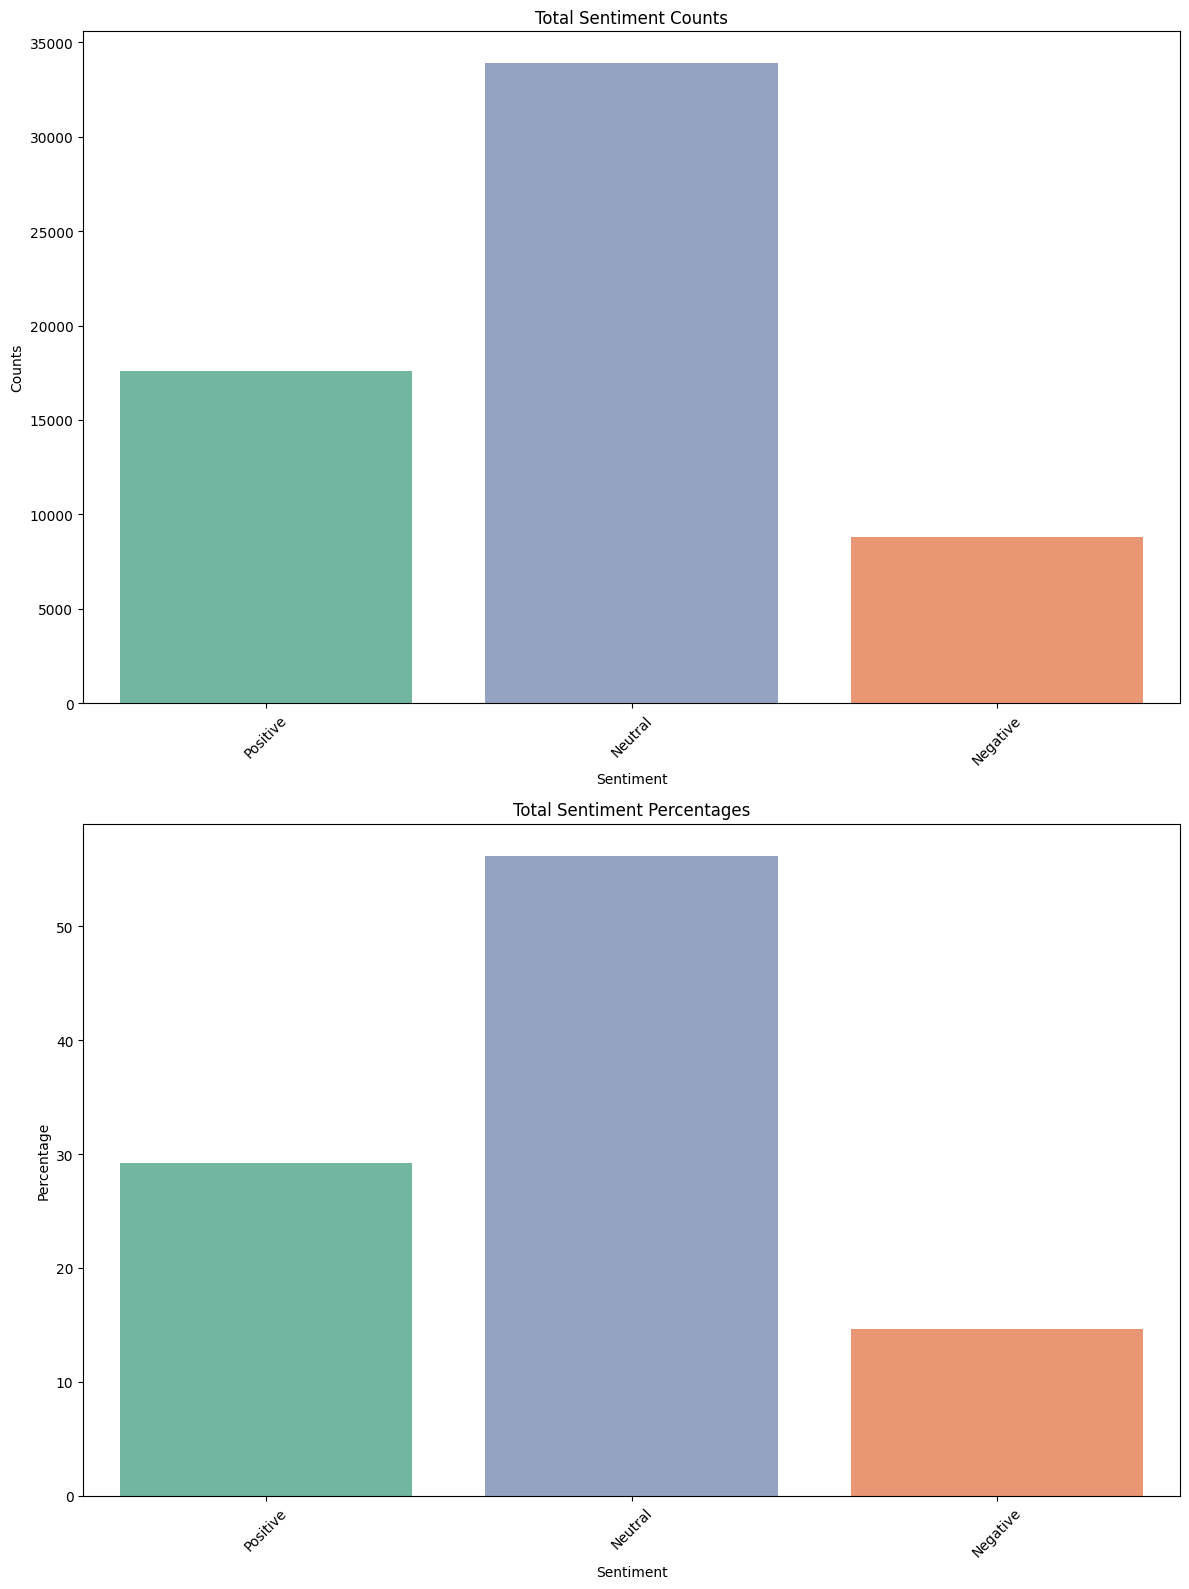

In [8]:
# Get total sentiment counts
melted_df = sentiment_df.melt(id_vars=['Source', 'Ticker', 'Date'], value_vars=SENTIMENT_COLUMNS,
                              var_name='Sentiment_Category', value_name='Sentiment')

# Group by sentiment, then count the occurrences
grouped_df = melted_df.groupby(['Sentiment']).size().reset_index(name='Counts')

# Calculate total counts
total_counts = grouped_df['Counts'].sum()

# Calculate the percentage
grouped_df['Percentage'] = (grouped_df['Counts'] / total_counts) * 100

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot the counts
sns.barplot(data=grouped_df, x='Sentiment', y='Counts', hue='Sentiment', palette=PALETTE, ax=ax1, order=HUE_ORDER, dodge=False, legend=False)
ax1.set_title('Total Sentiment Counts')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Counts')
ax1.tick_params(axis='x', rotation=45)

# Plot the percentages
sns.barplot(data=grouped_df, x='Sentiment', y='Percentage', hue='Sentiment', palette=PALETTE, ax=ax2, order=HUE_ORDER, dodge=False, legend=False)
ax2.set_title('Total Sentiment Percentages')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Percentage')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

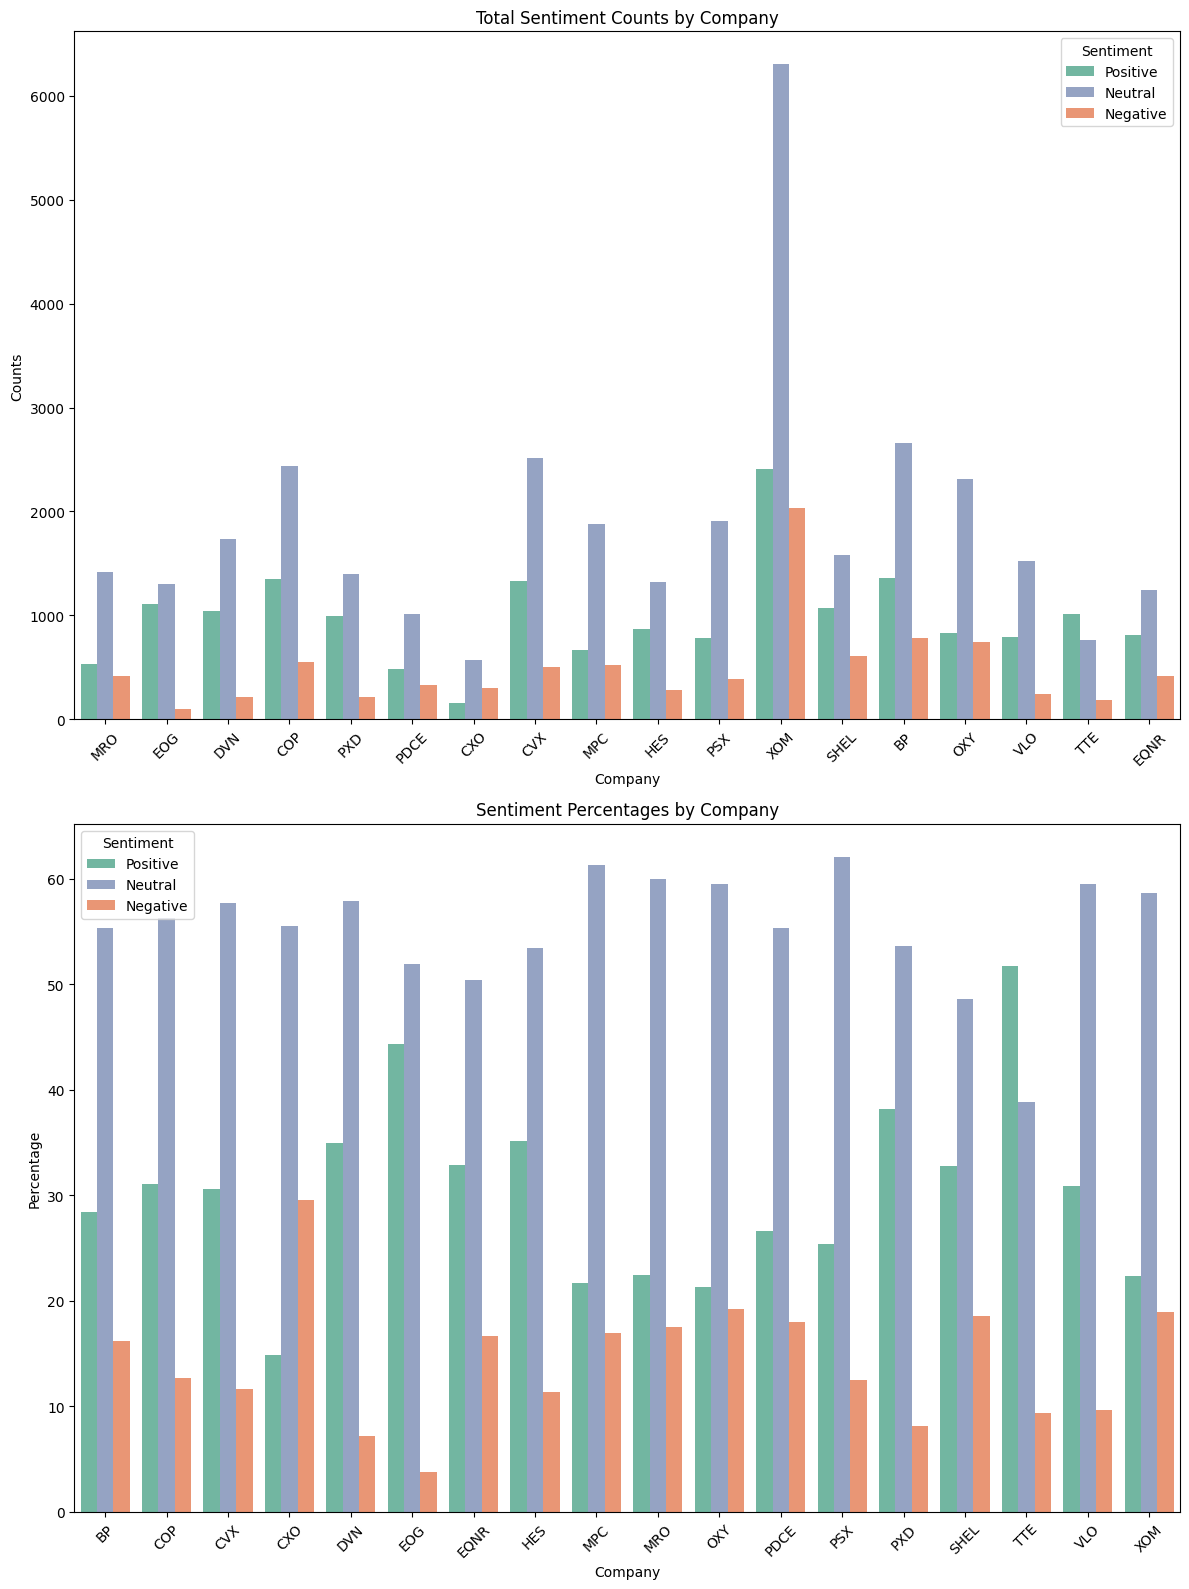

In [9]:
# Plot sentiment counts by company
melted_df = sentiment_df.melt(id_vars=['Source', 'Ticker', 'Date'], value_vars=SENTIMENT_COLUMNS,
                              var_name='Sentiment_Category', value_name='Sentiment')

# Group by company and sentiment, then count the occurrences
grouped_df = melted_df.groupby(['Ticker', 'Sentiment']).size().reset_index(name='Counts')

# Calculate total counts for each Ticker
total_counts = grouped_df.groupby('Ticker')['Counts'].transform('sum')

# Calculate the percentage
grouped_df['Percentage'] = (grouped_df['Counts'] / total_counts) * 100

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot the counts
sns.countplot(data=melted_df, x='Ticker', hue='Sentiment', palette=PALETTE, hue_order=HUE_ORDER, ax=ax1)
ax1.set_title('Total Sentiment Counts by Company')
ax1.set_xlabel('Company')
ax1.set_ylabel('Counts')
ax1.tick_params(axis='x', rotation=45)

# Plot the percentages
sns.barplot(data=grouped_df, x='Ticker', y='Percentage', hue='Sentiment', palette=PALETTE, hue_order=HUE_ORDER, ax=ax2)
ax2.set_title('Sentiment Percentages by Company')
ax2.set_xlabel('Company')
ax2.set_ylabel('Percentage')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

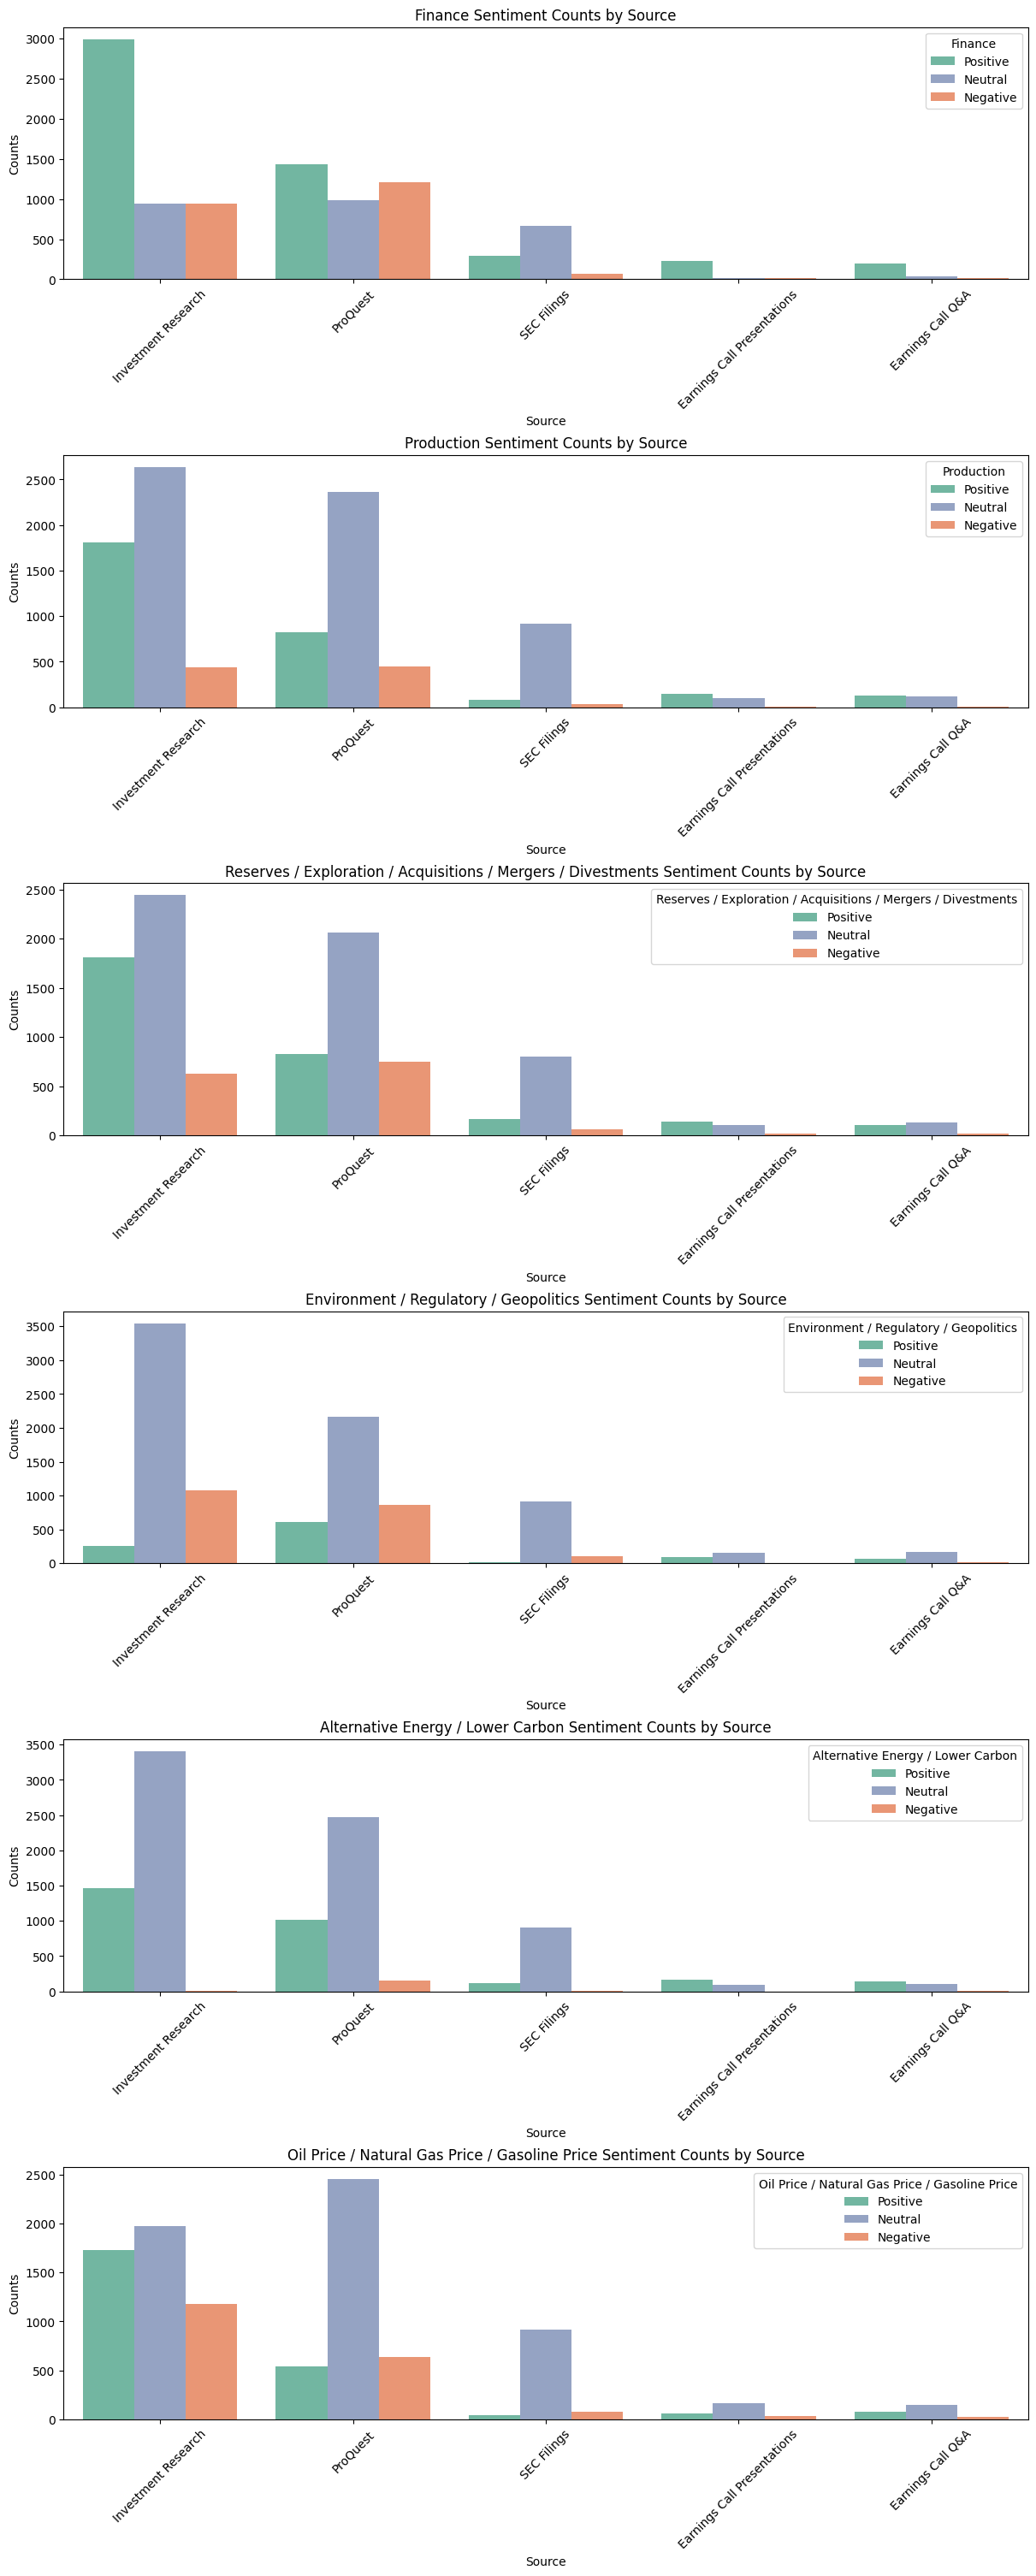

In [10]:
# Plot sentiment counts by category
fig, axes = plt.subplots(nrows=len(SENTIMENT_COLUMNS), ncols=1, figsize=(12, len(SENTIMENT_COLUMNS) * 5), constrained_layout=True)

# Plot each sentiment category
for i, column in enumerate(SENTIMENT_COLUMNS):
    sns.countplot(data=sentiment_df, x='Source', hue=column, ax=axes[i], palette=PALETTE, hue_order=HUE_ORDER)
    axes[i].set_title(f'{column} Sentiment Counts by Source')
    axes[i].set_xlabel('Source')
    axes[i].set_ylabel('Counts')
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

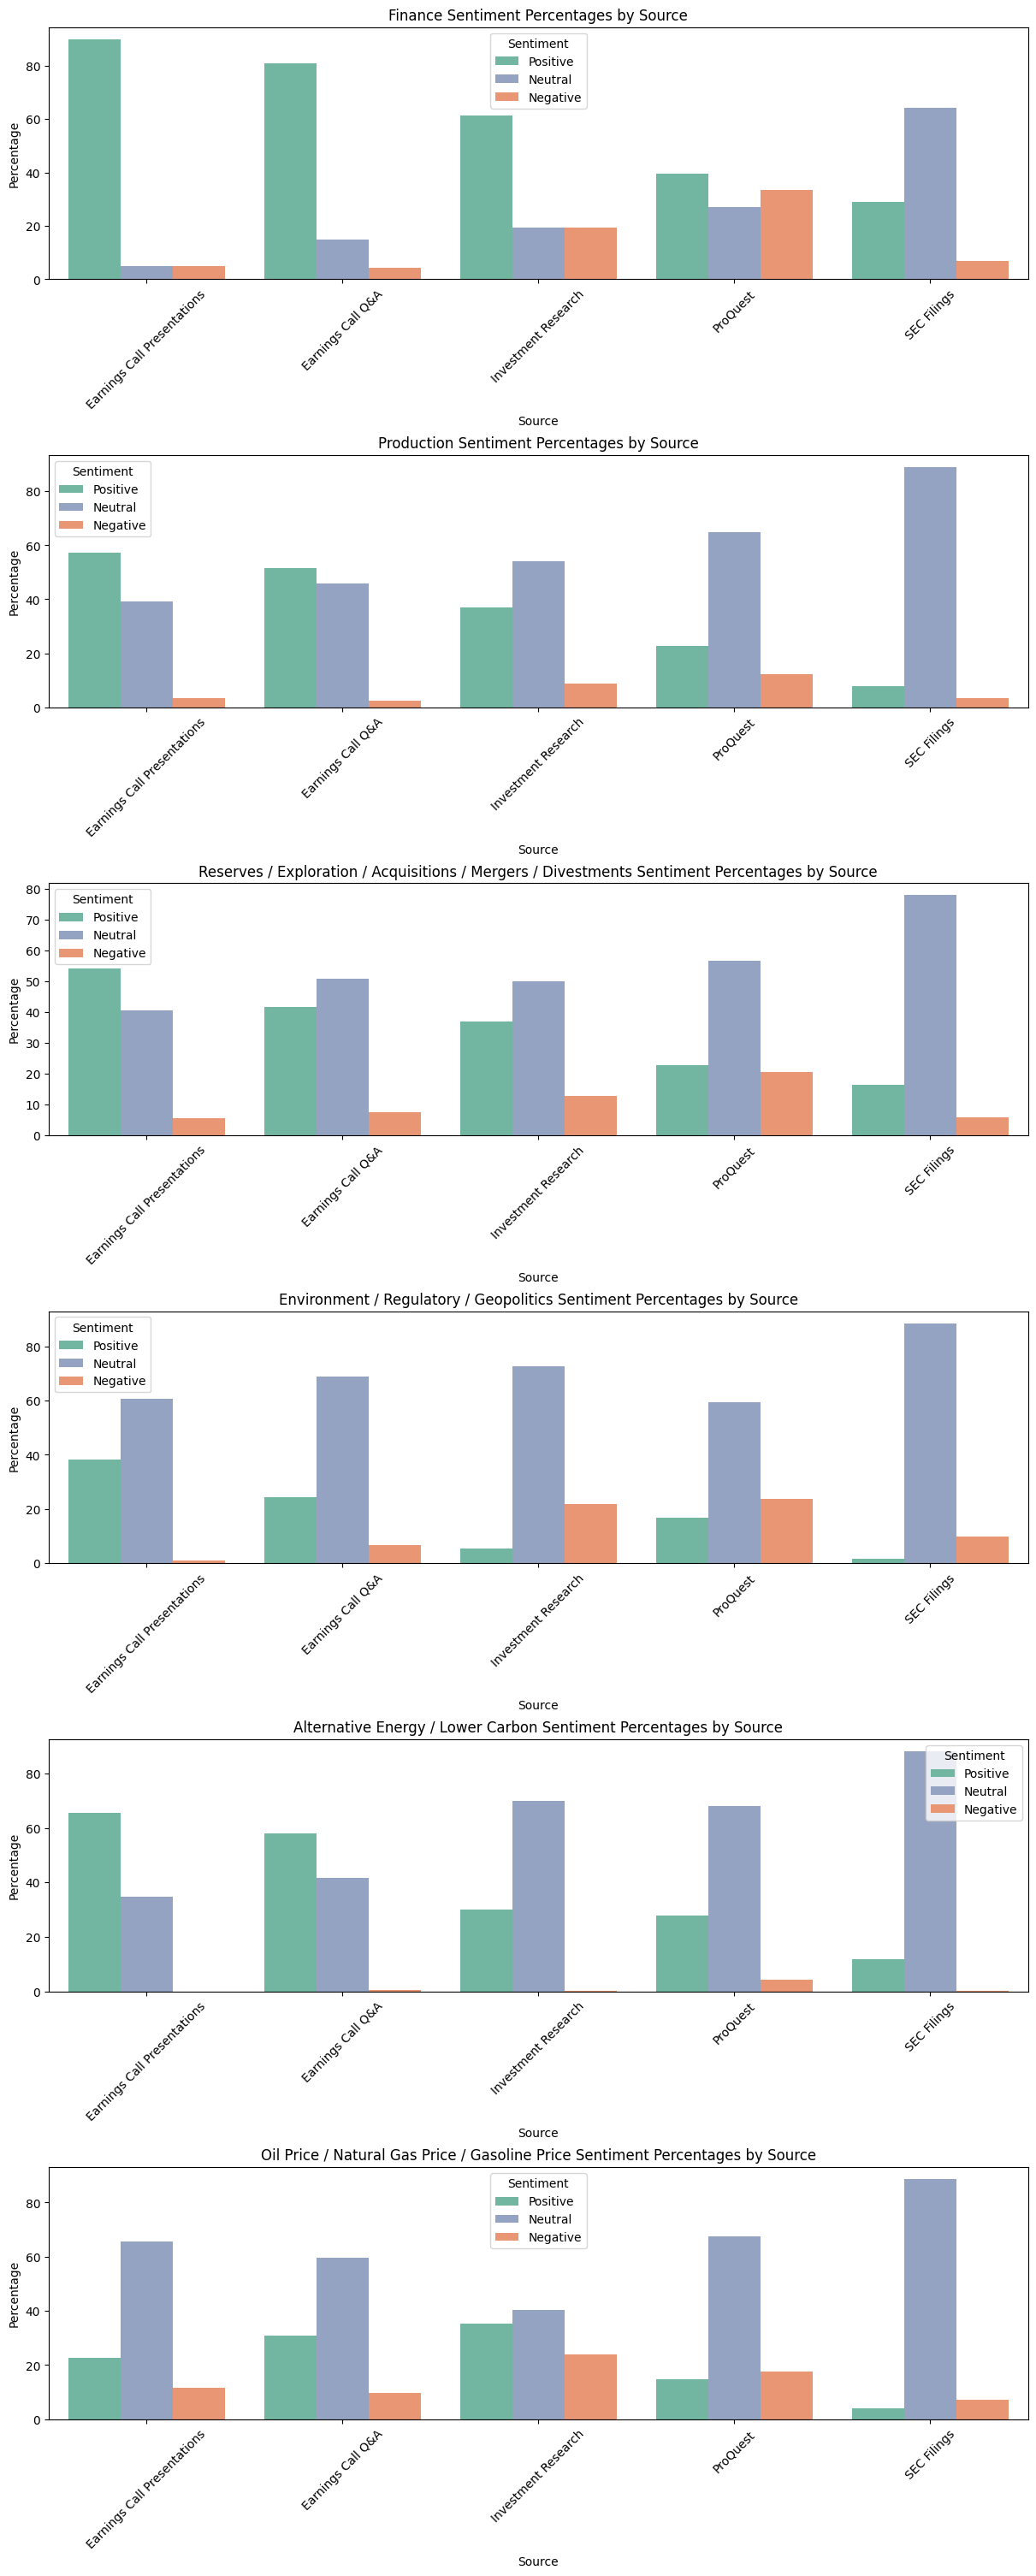

In [11]:
# Plot sentiment percentages by category
fig, axes = plt.subplots(nrows=len(SENTIMENT_COLUMNS), ncols=1, figsize=(12, len(SENTIMENT_COLUMNS) * 5), constrained_layout=True)

# Plot each sentiment category
for i, column in enumerate(SENTIMENT_COLUMNS):
    # Group by Source and sentiment, then count the occurrences
    melted_df = sentiment_df.melt(id_vars=['Source', 'Ticker', 'Date'], value_vars=[column],
                                  var_name='Sentiment_Category', value_name='Sentiment')
    grouped_df = melted_df.groupby(['Source', 'Sentiment']).size().reset_index(name='Counts')

    # Calculate total counts for each Source
    total_counts = grouped_df.groupby('Source')['Counts'].transform('sum')

    # Calculate the percentage
    grouped_df['Percentage'] = (grouped_df['Counts'] / total_counts) * 100

    # Plot the percentages
    sns.barplot(data=grouped_df, x='Source', y='Percentage', hue='Sentiment', palette=PALETTE, hue_order=HUE_ORDER, ax=axes[i])
    axes[i].set_title(f'{column} Sentiment Percentages by Source')
    axes[i].set_xlabel('Source')
    axes[i].set_ylabel('Percentage')
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

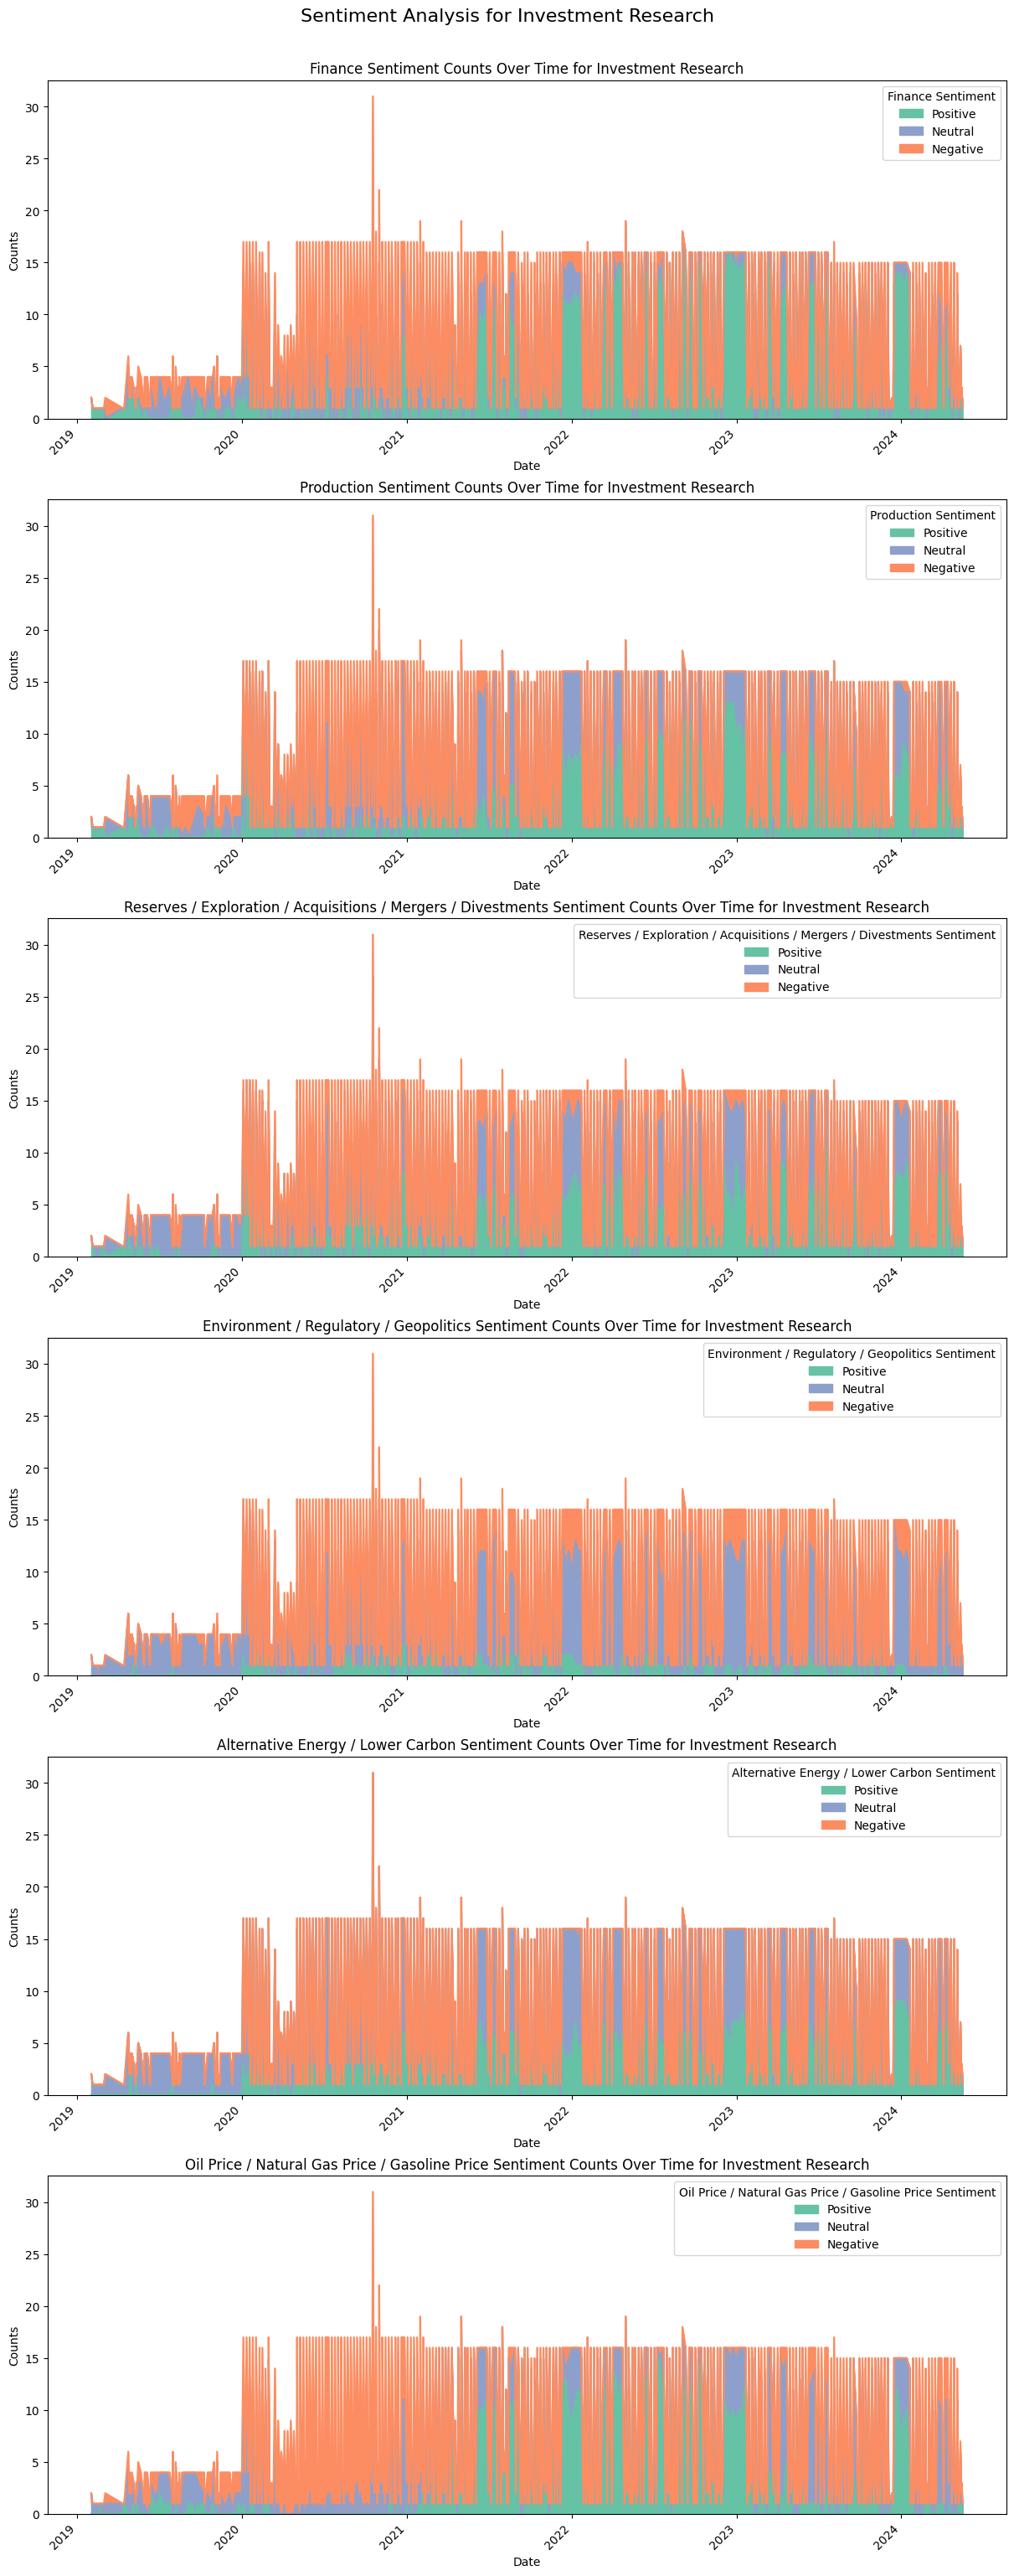

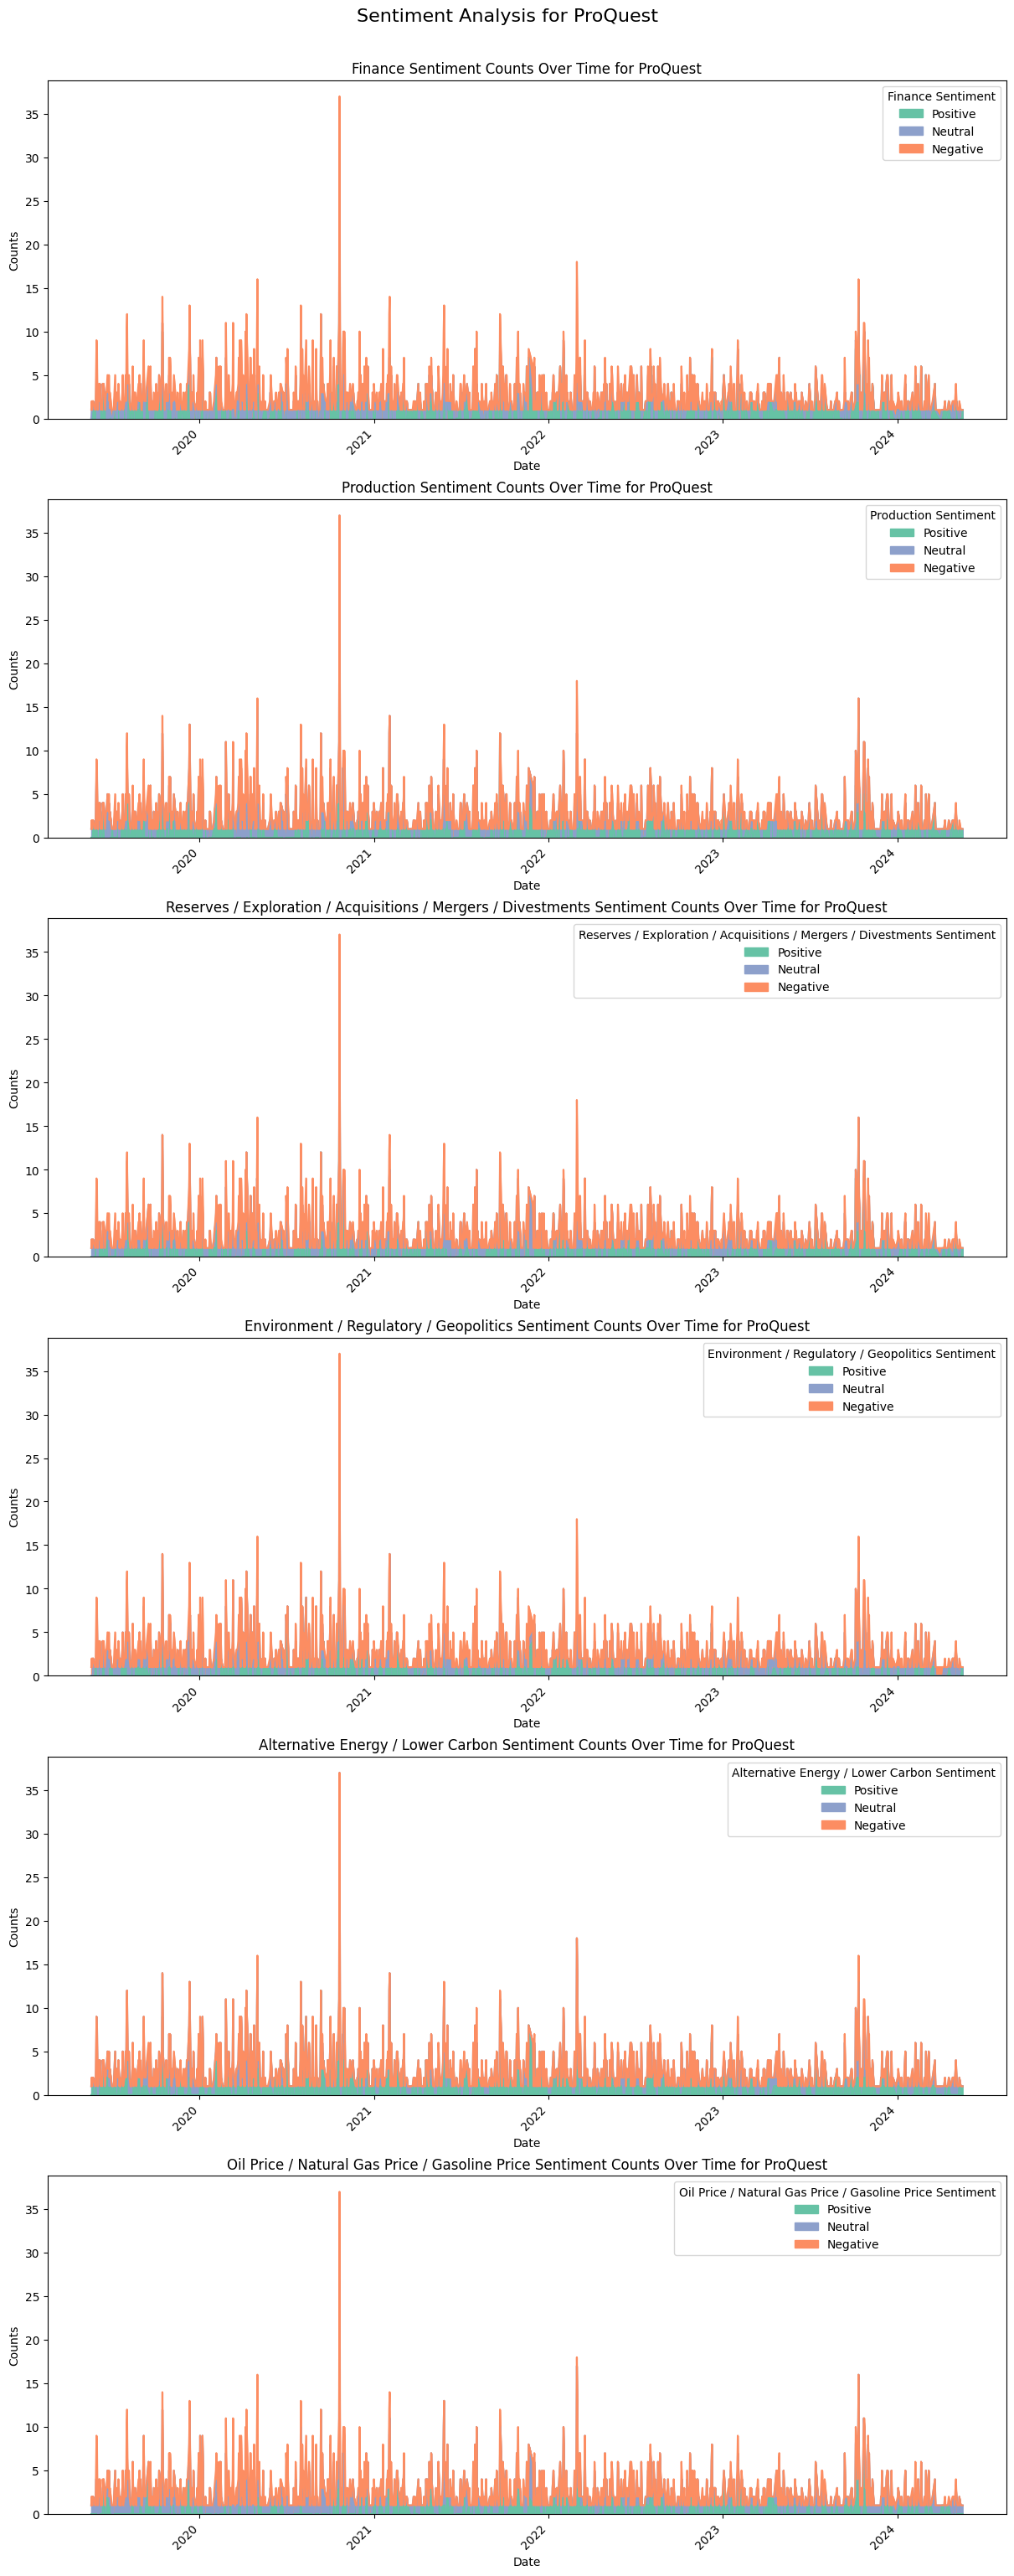

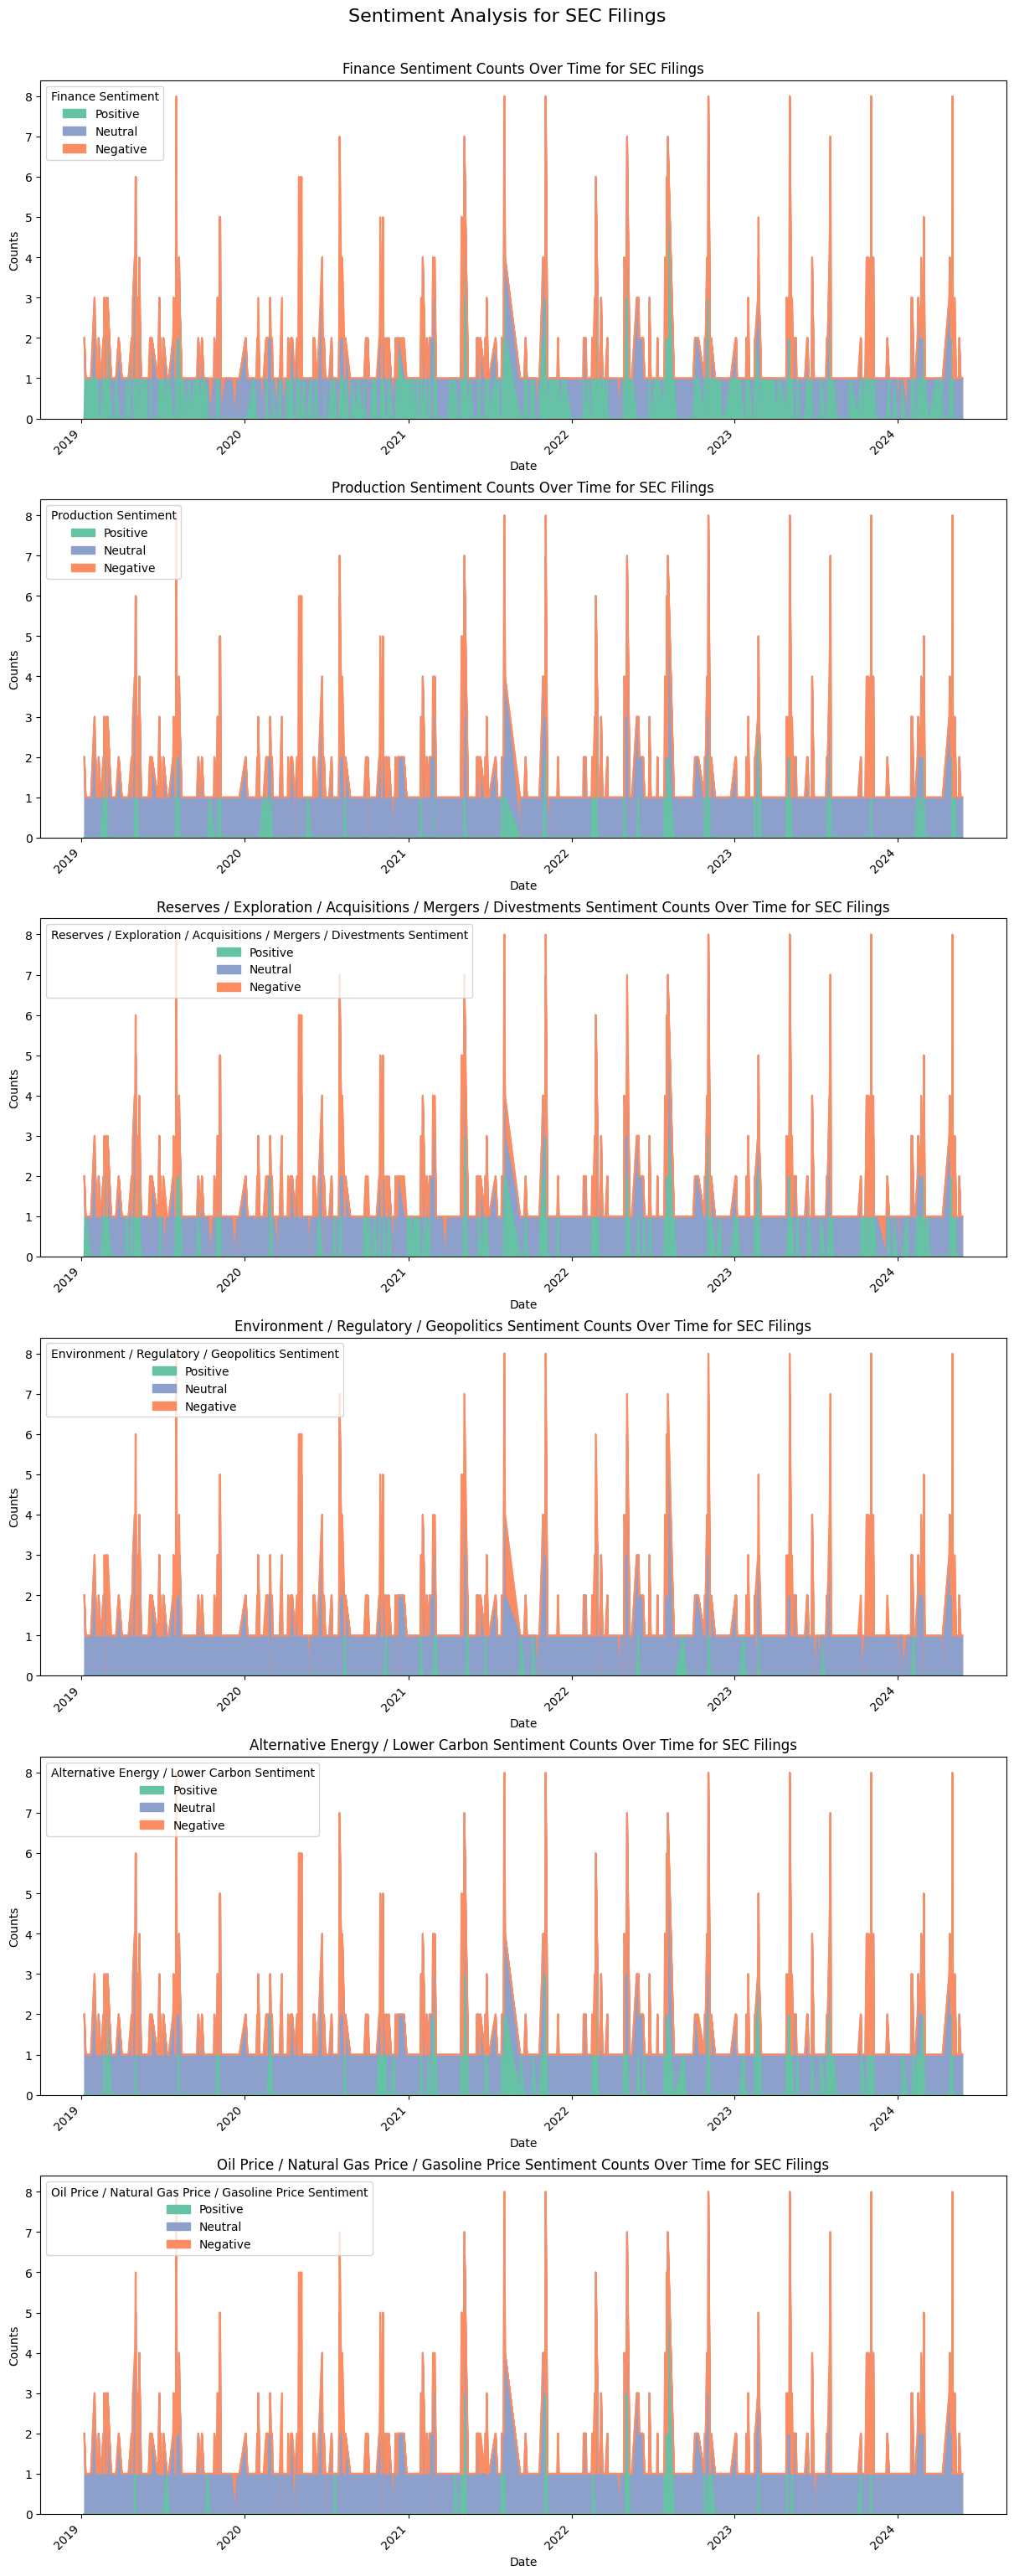

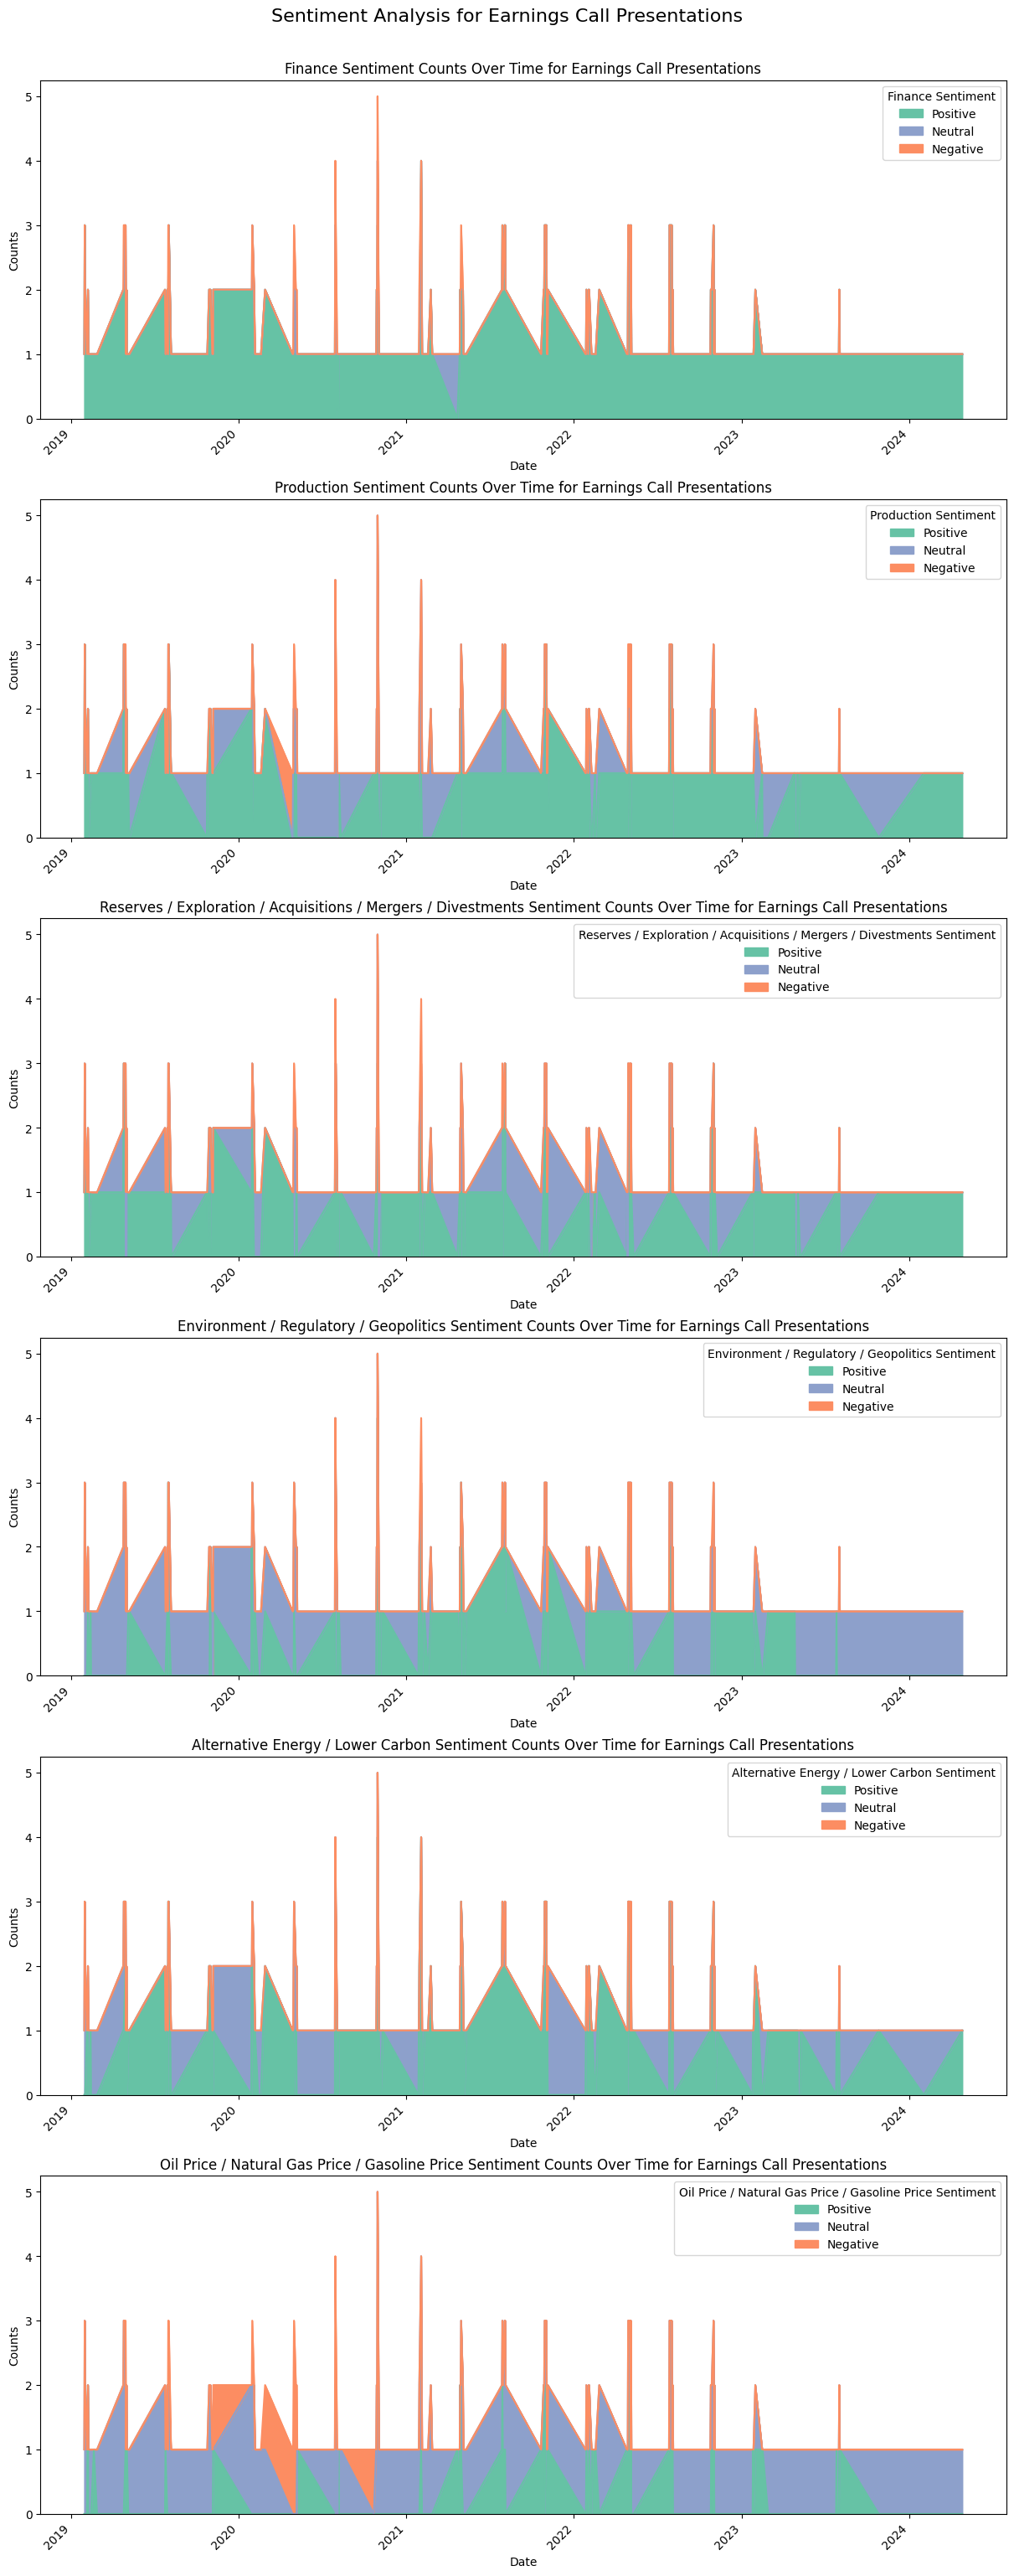

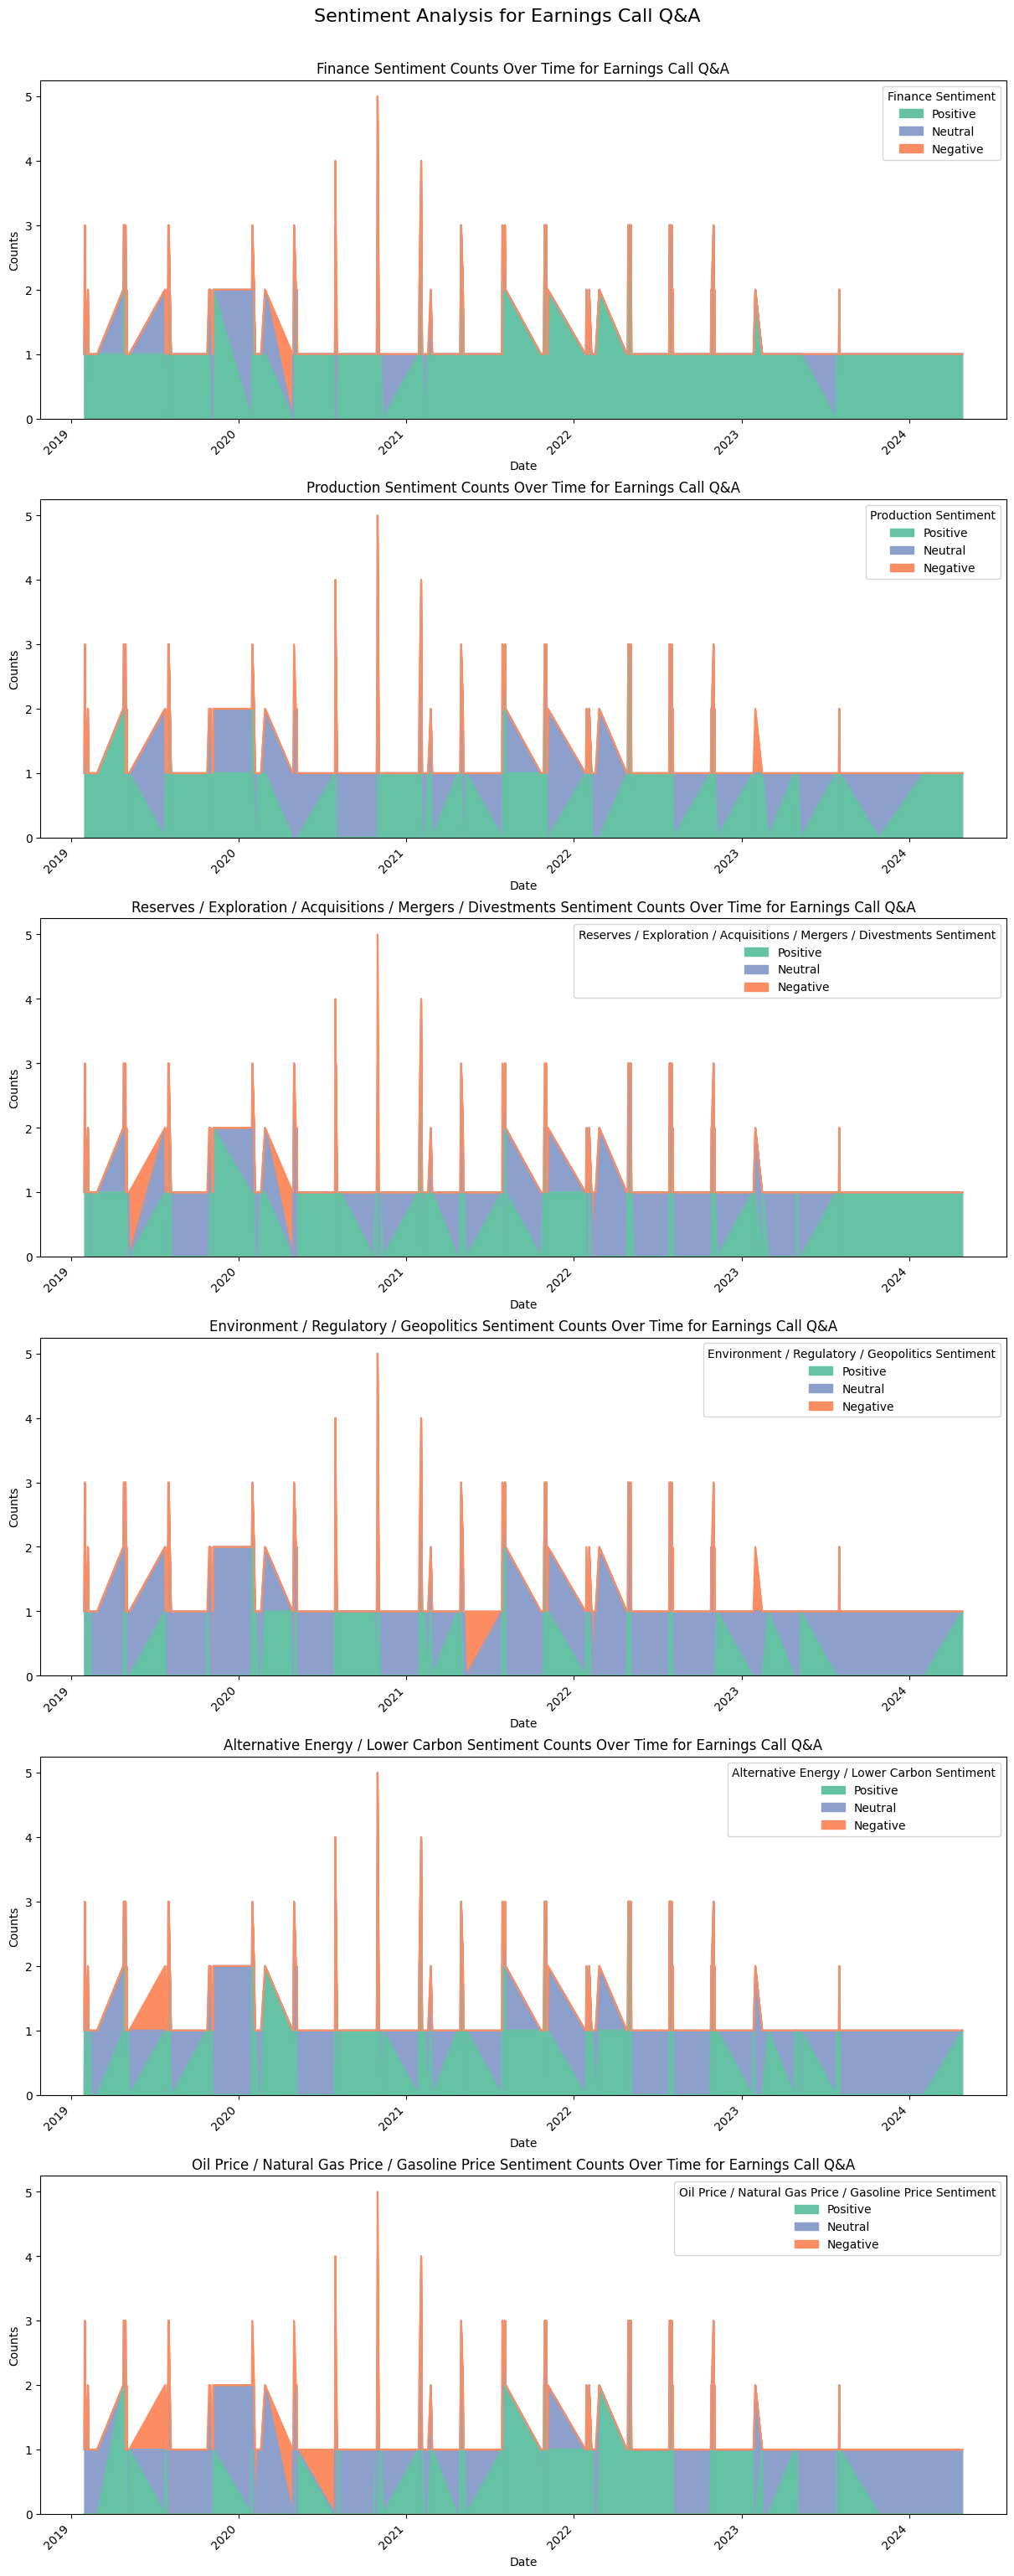

In [12]:
# Plot sentiment over time
sources = sentiment_df['Source'].unique()
for source in sources:
    source_df = sentiment_df[sentiment_df['Source'] == source]

    # Create subplots
    fig, axes = plt.subplots(nrows=len(SENTIMENT_COLUMNS), ncols=1, figsize=(12, len(SENTIMENT_COLUMNS) * 5), constrained_layout=True)

    # Plot each sentiment category over time using stacked area plot
    for i, column in enumerate(SENTIMENT_COLUMNS):
        df_melted = source_df.melt(id_vars=['Date'], value_vars=[column], var_name='Sentiment_Type', value_name='Sentiment')
        df_grouped = df_melted.groupby(['Date', 'Sentiment']).size().reset_index(name='Counts')
        df_pivot = df_grouped.pivot(index='Date', columns='Sentiment', values='Counts')

        # Reorder columns to match hue_order
        df_pivot = df_pivot.reindex(columns=HUE_ORDER)

        df_pivot.plot(kind='area', stacked=True, ax=axes[i], color=[PALETTE[sent] for sent in HUE_ORDER])
        axes[i].set_title(f'{column} Sentiment Counts Over Time for {source}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Counts')
        axes[i].legend(title=f'{column} Sentiment')
        axes[i].tick_params(axis='x', rotation=45)

    # Show the plot for the current source
    plt.suptitle(f'Sentiment Analysis for {source}', y=1.02, fontsize=16)
    plt.show()